# Loan Charge-off Predictive Model
Predicting how likely it is for a loan (issued in 2016) to become charge-off

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./data/accepted_2007_to_2018Q4.csv.gz", compression='gzip')

In [3]:
len(df)

2260701

In [4]:
df['id'].nunique()

2260701

In [5]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [9]:
for col in df.columns:
    print(col)

id
member_id
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_title
emp_length
home_ownership
annual_inc
verification_status
issue_d
loan_status
pymnt_plan
url
desc
purpose
title
zip_code
addr_state
dti
delinq_2yrs
earliest_cr_line
fico_range_low
fico_range_high
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
initial_list_status
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_d
last_pymnt_amnt
next_pymnt_d
last_credit_pull_d
last_fico_range_high
last_fico_range_low
collections_12_mths_ex_med
mths_since_last_major_derog
policy_code
application_type
annual_inc_joint
dti_joint
verification_status_joint
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_act_il
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
to

In [10]:
df['issue_d'].sample(10)

376965     Feb-2015
1215279    Aug-2014
506161     Jan-2018
1027541    Mar-2016
2123726    Oct-2017
94265      Oct-2015
950886     May-2017
620514     Jul-2017
1813172    Aug-2013
2127286    Oct-2017
Name: issue_d, dtype: object

In [11]:
# Removing instances with null issue date
df.dropna(subset= ['issue_d'], inplace=True)

### Loans Issued in 2016
The problem requires to predict loan charge-off probablity that are issued in 2016. For now, I'm going to use 2016 loan data only for exploration and modeling purposes. Later on, we can potentially levarage loans issued in other years to improve the model.

In [12]:
loans_2016 = df[df['issue_d'].str.contains("2016")]

In [13]:
len(loans_2016)

434407

Text(0.5, 1.0, 'Loans Issued in 2016')

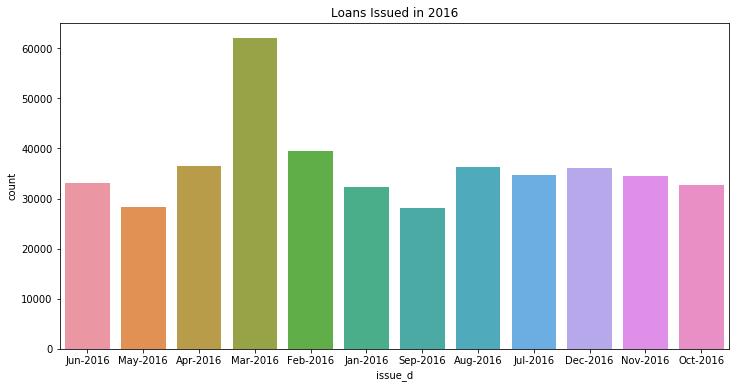

In [14]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
sns.countplot(x='issue_d', data = loans_2016, ax=ax)
ax.set_title("Loans Issued in 2016")

In [15]:
loans_2016['loan_status'].value_counts(dropna=False)

Fully Paid            224853
Current               134061
Charged Off            68242
Late (31-120 days)      4546
In Grace Period         1793
Late (16-30 days)        902
Default                   10
Name: loan_status, dtype: int64

### Target Feature
* The model is expected to predict wether an issued loan will get a charge-off status or not. Therefore, the model should gain a discriminative power to distinguish unhealthy (to-be charge-off) loans vs. healthy loans. 
* There are two statuses in the dataset which can be indicators for a healthy loan: __current__, which is an ongoing loan with no past due payment, and __fully paid__ loan, which has been fully paid off. The other loan statuses are not indicators of healthy loan, therefore, I'm ignoring thoses statuses for now.
* As a result, I'm limitting the data set to the loans with Charge-Off, Current, and Fully Paid status

In [16]:
fcc_2016 = loans_2016.query("loan_status=='Fully Paid' or loan_status=='Current' or loan_status=='Charged Off'")

In [17]:
fcc_2016['loan_status'].value_counts(dropna=False)

Fully Paid     224853
Current        134061
Charged Off     68242
Name: loan_status, dtype: int64

### Handling Missing Values

In [18]:
nullValuesPer = fcc_2016.isnull().mean().to_frame("missing_per")
nullValuesPer["missing_per"] = nullValuesPer["missing_per"] * 100

In [19]:
nullValuesPer.query("missing_per > 35.0").sample(5)

,missing_per
sec_app_inq_last_6mths,100.000000
mths_since_last_delinq,47.233095
sec_app_mths_since_last_major_derog,100.000000
mths_since_recent_bc_dlq,74.464833
next_pymnt_d,68.615447


In [20]:
nullValuesPer.query("missing_per > 35.0").count()

missing_per    44
dtype: int64

__Observation:__
There are 44 features with more than 35% missing values. For features with considarable missing value percentage, there is a need to do case-by-case investigation. To develop a base preliminary model, I'm going to remove these features for now.

In [21]:
candid_features = nullValuesPer.query("missing_per < 35.0")

In [22]:
len(candid_features)

107

In [23]:
candid_features["missing_per"].max(), candid_features["missing_per"].min()

(13.23872308945678, 0.0)

__Candidate Features__: After removing features with >35% missing values, we have 107 remaining candidate features

In [24]:
canfeatures_list = candid_features.index.to_list()

In [25]:
canfeatures_list

['id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_ba

### Limiting The Feature Space
* As the model is performing prediction on loans at the time of loan application/start, the model has to rely on features that are available to investors at the time of application only.
* Based on my research, and also the information I acquired from Lending Club docs, the following features seem to be the ones that are available at the time of loan application submission/ loan origination.

In [26]:
# Features (out of 107 candidate features) that are available to investor while loan application is submitted.
valid_features_list = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade','emp_title','emp_length',\
                 'home_ownership', 'annual_inc', 'verification_status','issue_d', 'loan_status', 'purpose', \
                  'title','zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_high', 'fico_range_low',\
                  'total_acc', 'open_acc', 'initial_list_status', 'application_type']

# numeric features
numerics = ['loan_amnt', 'int_rate', 'installment', 'annual_inc','dti','fico_range_low','fico_range_high',\
            'total_acc', 'open_acc']

# categorical features
cats = ['term','grade','sub_grade','emp_length','home_ownership', 'verification_status','purpose', \
        'title','initial_list_status', 'application_type']

In [27]:
valid_features_df = fcc_2016[valid_features_list]

In [28]:
valid_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427156 entries, 651666 to 2260698
Data columns (total 25 columns):
loan_amnt              427156 non-null float64
term                   427156 non-null object
int_rate               427156 non-null float64
installment            427156 non-null float64
grade                  427156 non-null object
sub_grade              427156 non-null object
emp_title              399209 non-null object
emp_length             399487 non-null object
home_ownership         427156 non-null object
annual_inc             427156 non-null float64
verification_status    427156 non-null object
issue_d                427156 non-null object
loan_status            427156 non-null object
purpose                427156 non-null object
title                  404435 non-null object
zip_code               427156 non-null object
addr_state             427156 non-null object
dti                    427093 non-null float64
earliest_cr_line       427156 non-null object
fico

In [29]:
len(valid_features_df)

427156

### Binary Predictive Feature

As discussed, the model is going to predict high-likely charge-off loans against healthy (i.e. current or fully paid off) loans. Here, I'm gong to create a new binary (0/1) feature called 'label'. label=1 means charge-off loan, and label=0 means healthy loan.

In [30]:
def target_feature_value(row):
    if row['loan_status'] == "Charged Off":
        return 1
    else:
        return 0
    
valid_features_df['label'] = valid_features_df.apply(lambda row: target_feature_value(row), axis =1)

In [31]:
valid_features_df[['loan_status', 'label']].head(10)

,loan_status,label
651666,Fully Paid,0
651668,Current,0
651669,Current,0
651670,Fully Paid,0
651671,Current,0
651672,Current,0
651673,Fully Paid,0
651674,Charged Off,1
651675,Charged Off,1
651676,Fully Paid,0


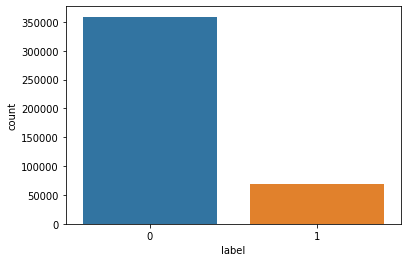

In [32]:
sns.countplot('label', data=valid_features_df)

In [33]:
len(valid_features_df.query("label == 1")) , len(valid_features_df.query("label == 0"))

(68242, 358914)

__Observation__: As can be guessed intuitively, there are far more healthy loans compared to charge-off loands, meaning that the data set is not balanced. 

## Analysis of The Numeric Features

### Numeric Features Value Ranges
Here, I'm going to have an overview of the numeric features value ranges

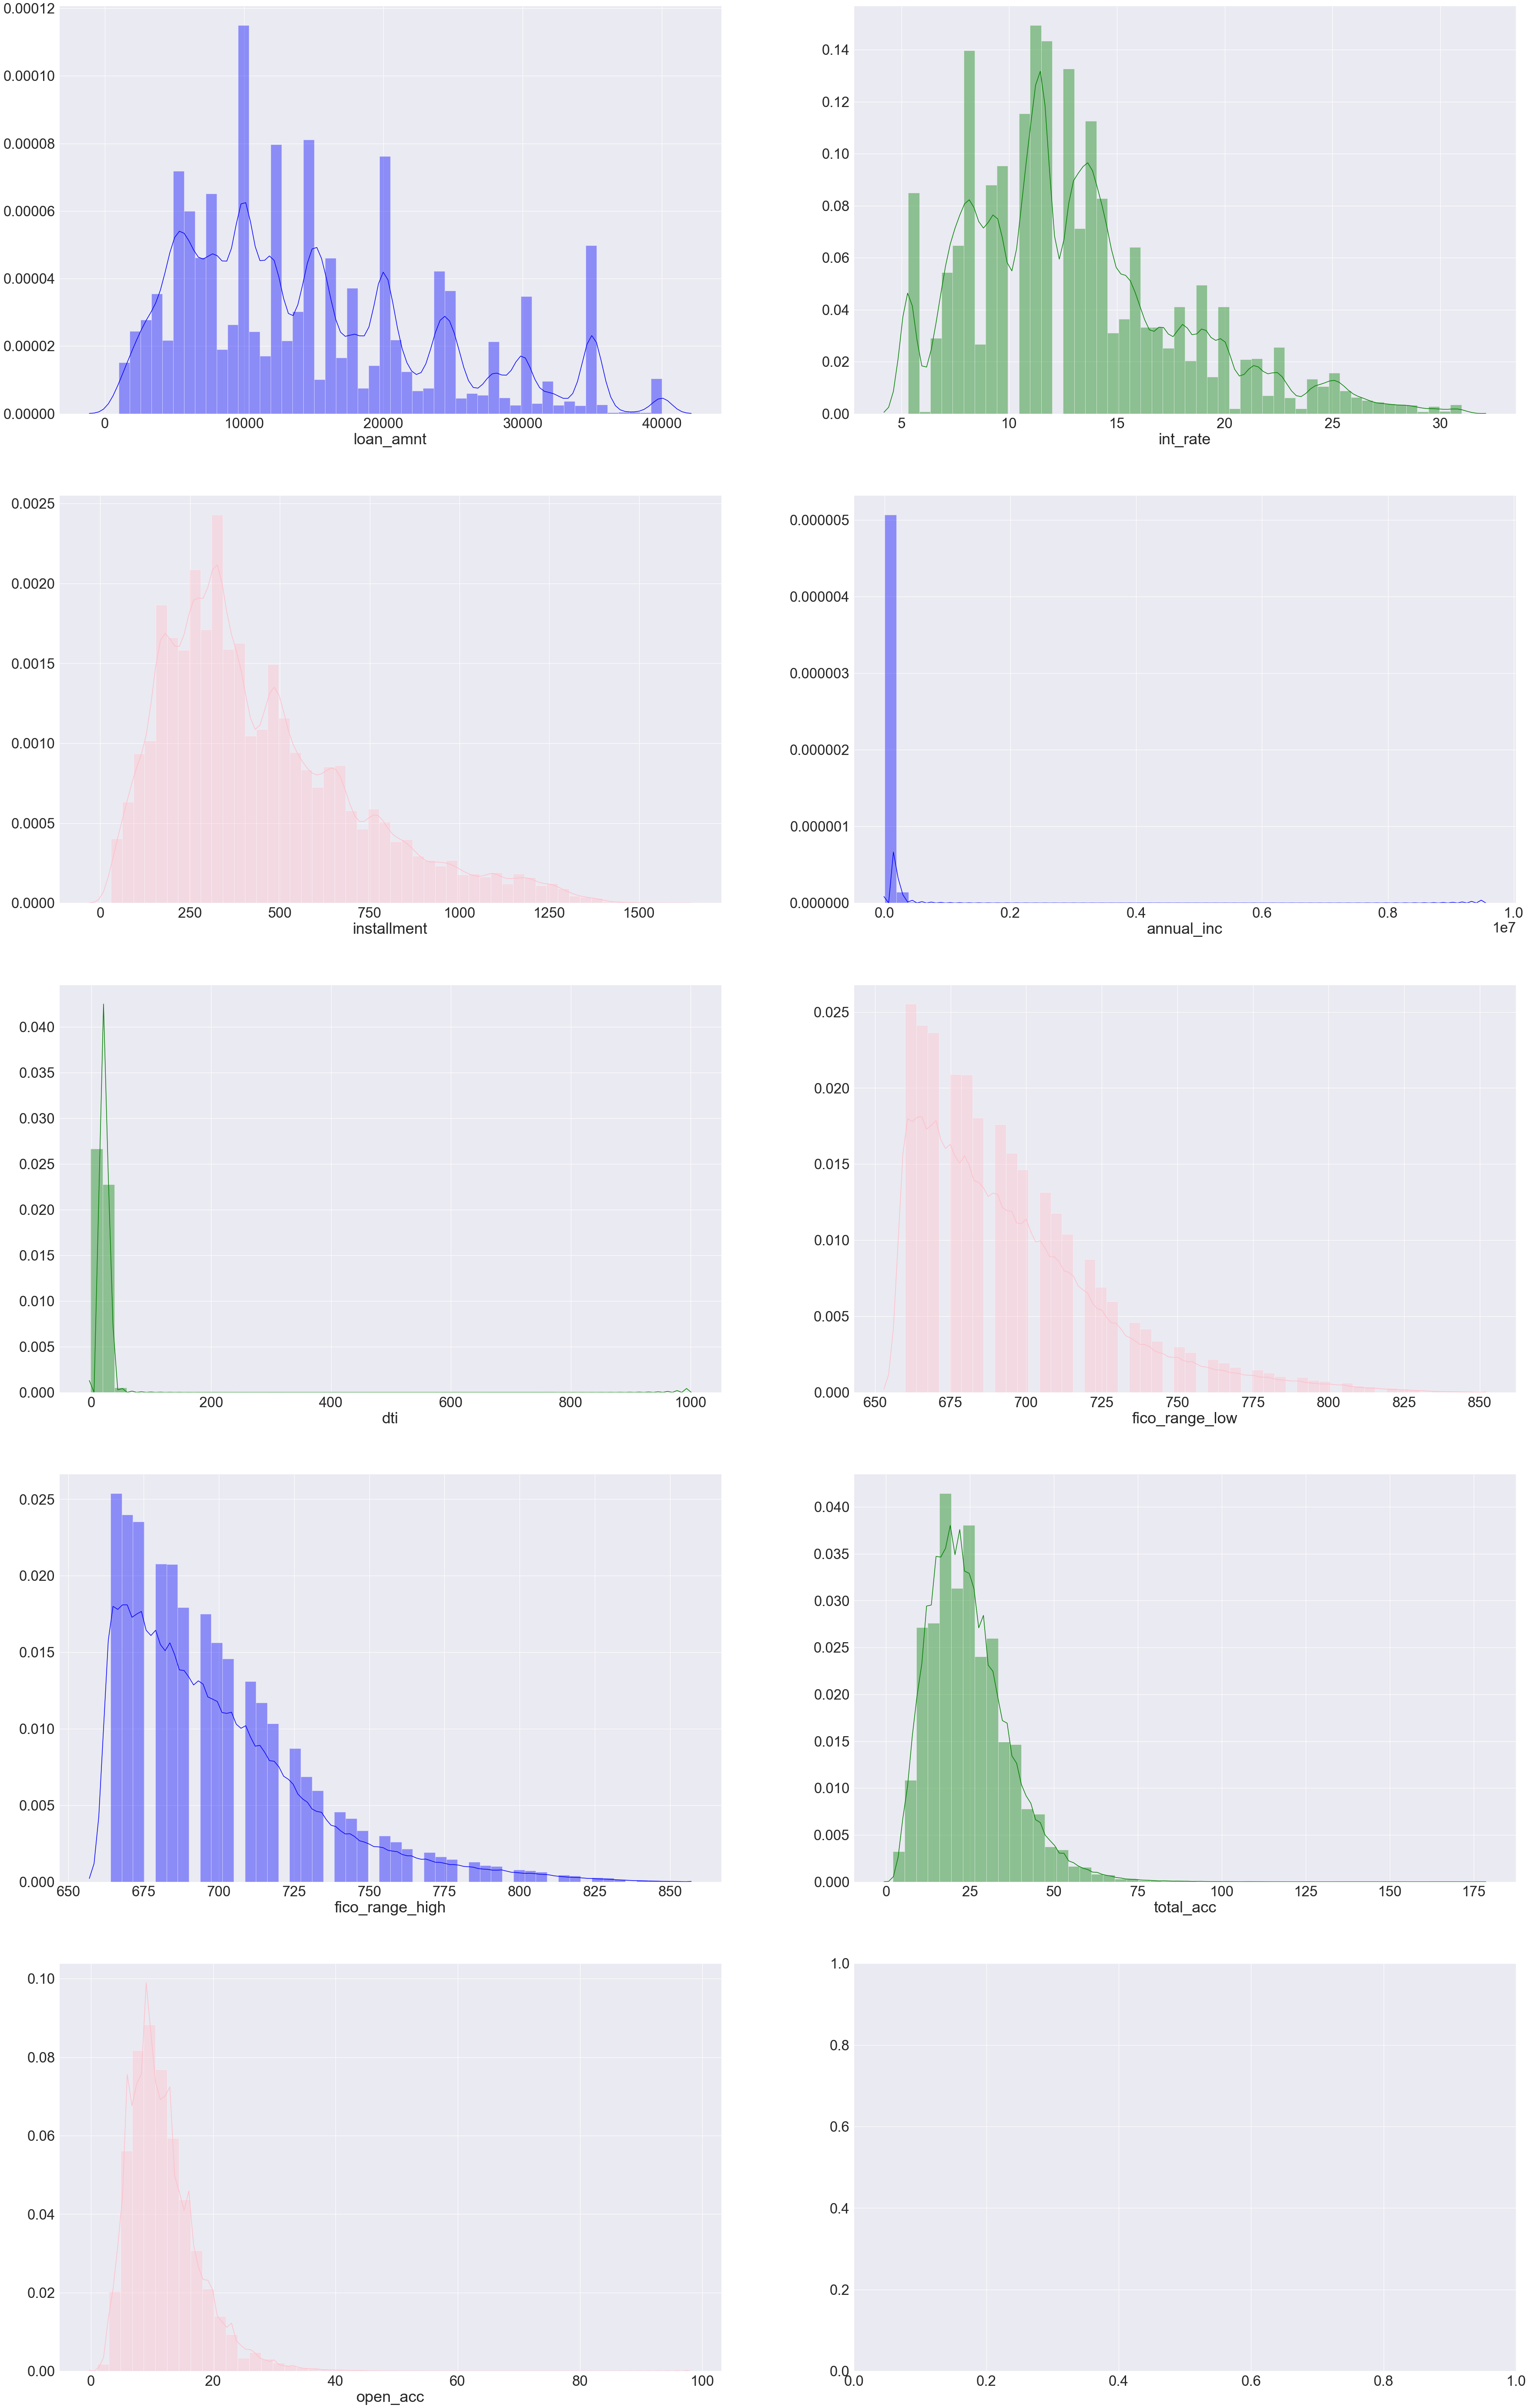

In [34]:
sns.set(font_scale=3)

n_numerics = len(numerics)
n_rows = int(n_numerics / 2) + (n_numerics % 2)
n_cols = 2

num_feature_count = 0
numerics_df = valid_features_df[numerics]

fig, axar = plt.subplots(ncols=n_cols, nrows= n_rows, figsize = (30 * n_cols , 20 * n_rows) )

colors = ['blue','green','pink']

for rw in range(n_rows):
    for cl in range(n_cols):
        if(num_feature_count < len(numerics)):
            sns.distplot(numerics_df.dropna(subset=[numerics[num_feature_count]])[numerics[num_feature_count]],\
                         ax = axar[rw][cl], kde=True, \
                         color = colors[int(num_feature_count % (len(colors)))])
            num_feature_count += 1

plt.show()

###### Taking a closer look to annual income (annual_inc) and debt to income ratio (dti):

In [35]:
valid_features_df['annual_inc'].describe()

count    4.271560e+05
mean     7.949017e+04
std      7.597223e+04
min      0.000000e+00
25%      4.800000e+04
50%      6.700000e+04
75%      9.500000e+04
max      9.550000e+06
Name: annual_inc, dtype: float64

In [36]:
valid_features_df['dti'].describe()

count    427093.000000
mean         18.849951
std          10.400677
min          -1.000000
25%          12.290000
50%          18.210000
75%          24.850000
max         999.000000
Name: dti, dtype: float64

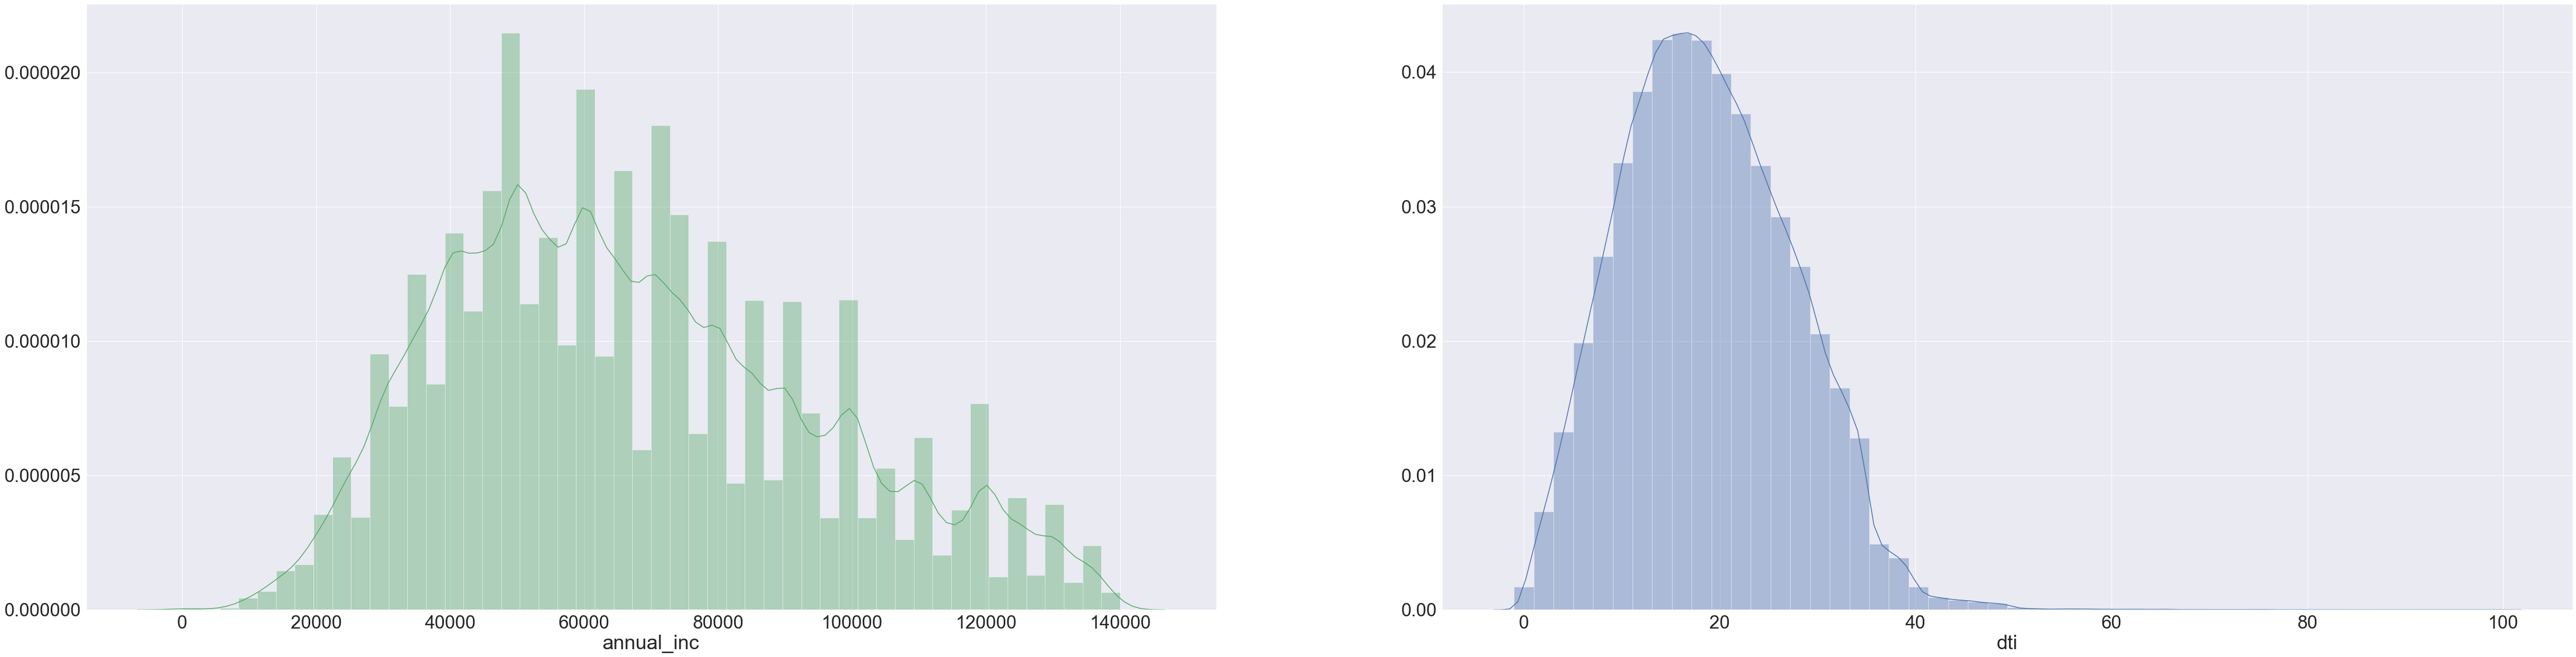

In [37]:
sns.set(font_scale=3)
fig , ax = plt.subplots(nrows=1, ncols=2, figsize=(80,20))
sns.distplot(valid_features_df.query("annual_inc < 140000")['annual_inc'], kde=True, color='g' ,ax = ax[0])
sns.distplot(valid_features_df.query("dti < 100")['dti'], kde=True, color='b', ax=ax[1])

### Scaling / Normalizing of The Numeric Features

In [38]:
from sklearn.preprocessing import RobustScaler, StandardScaler
rob_scaler = RobustScaler()

scaled_num_features_list = []

for num_feature in numerics:
    new_scaled_feature = num_feature+"_scaled"
    valid_features_df[new_scaled_feature] = \
            rob_scaler.fit_transform(valid_features_df[num_feature].values.reshape(-1,1))
    scaled_num_features_list.append(new_scaled_feature)

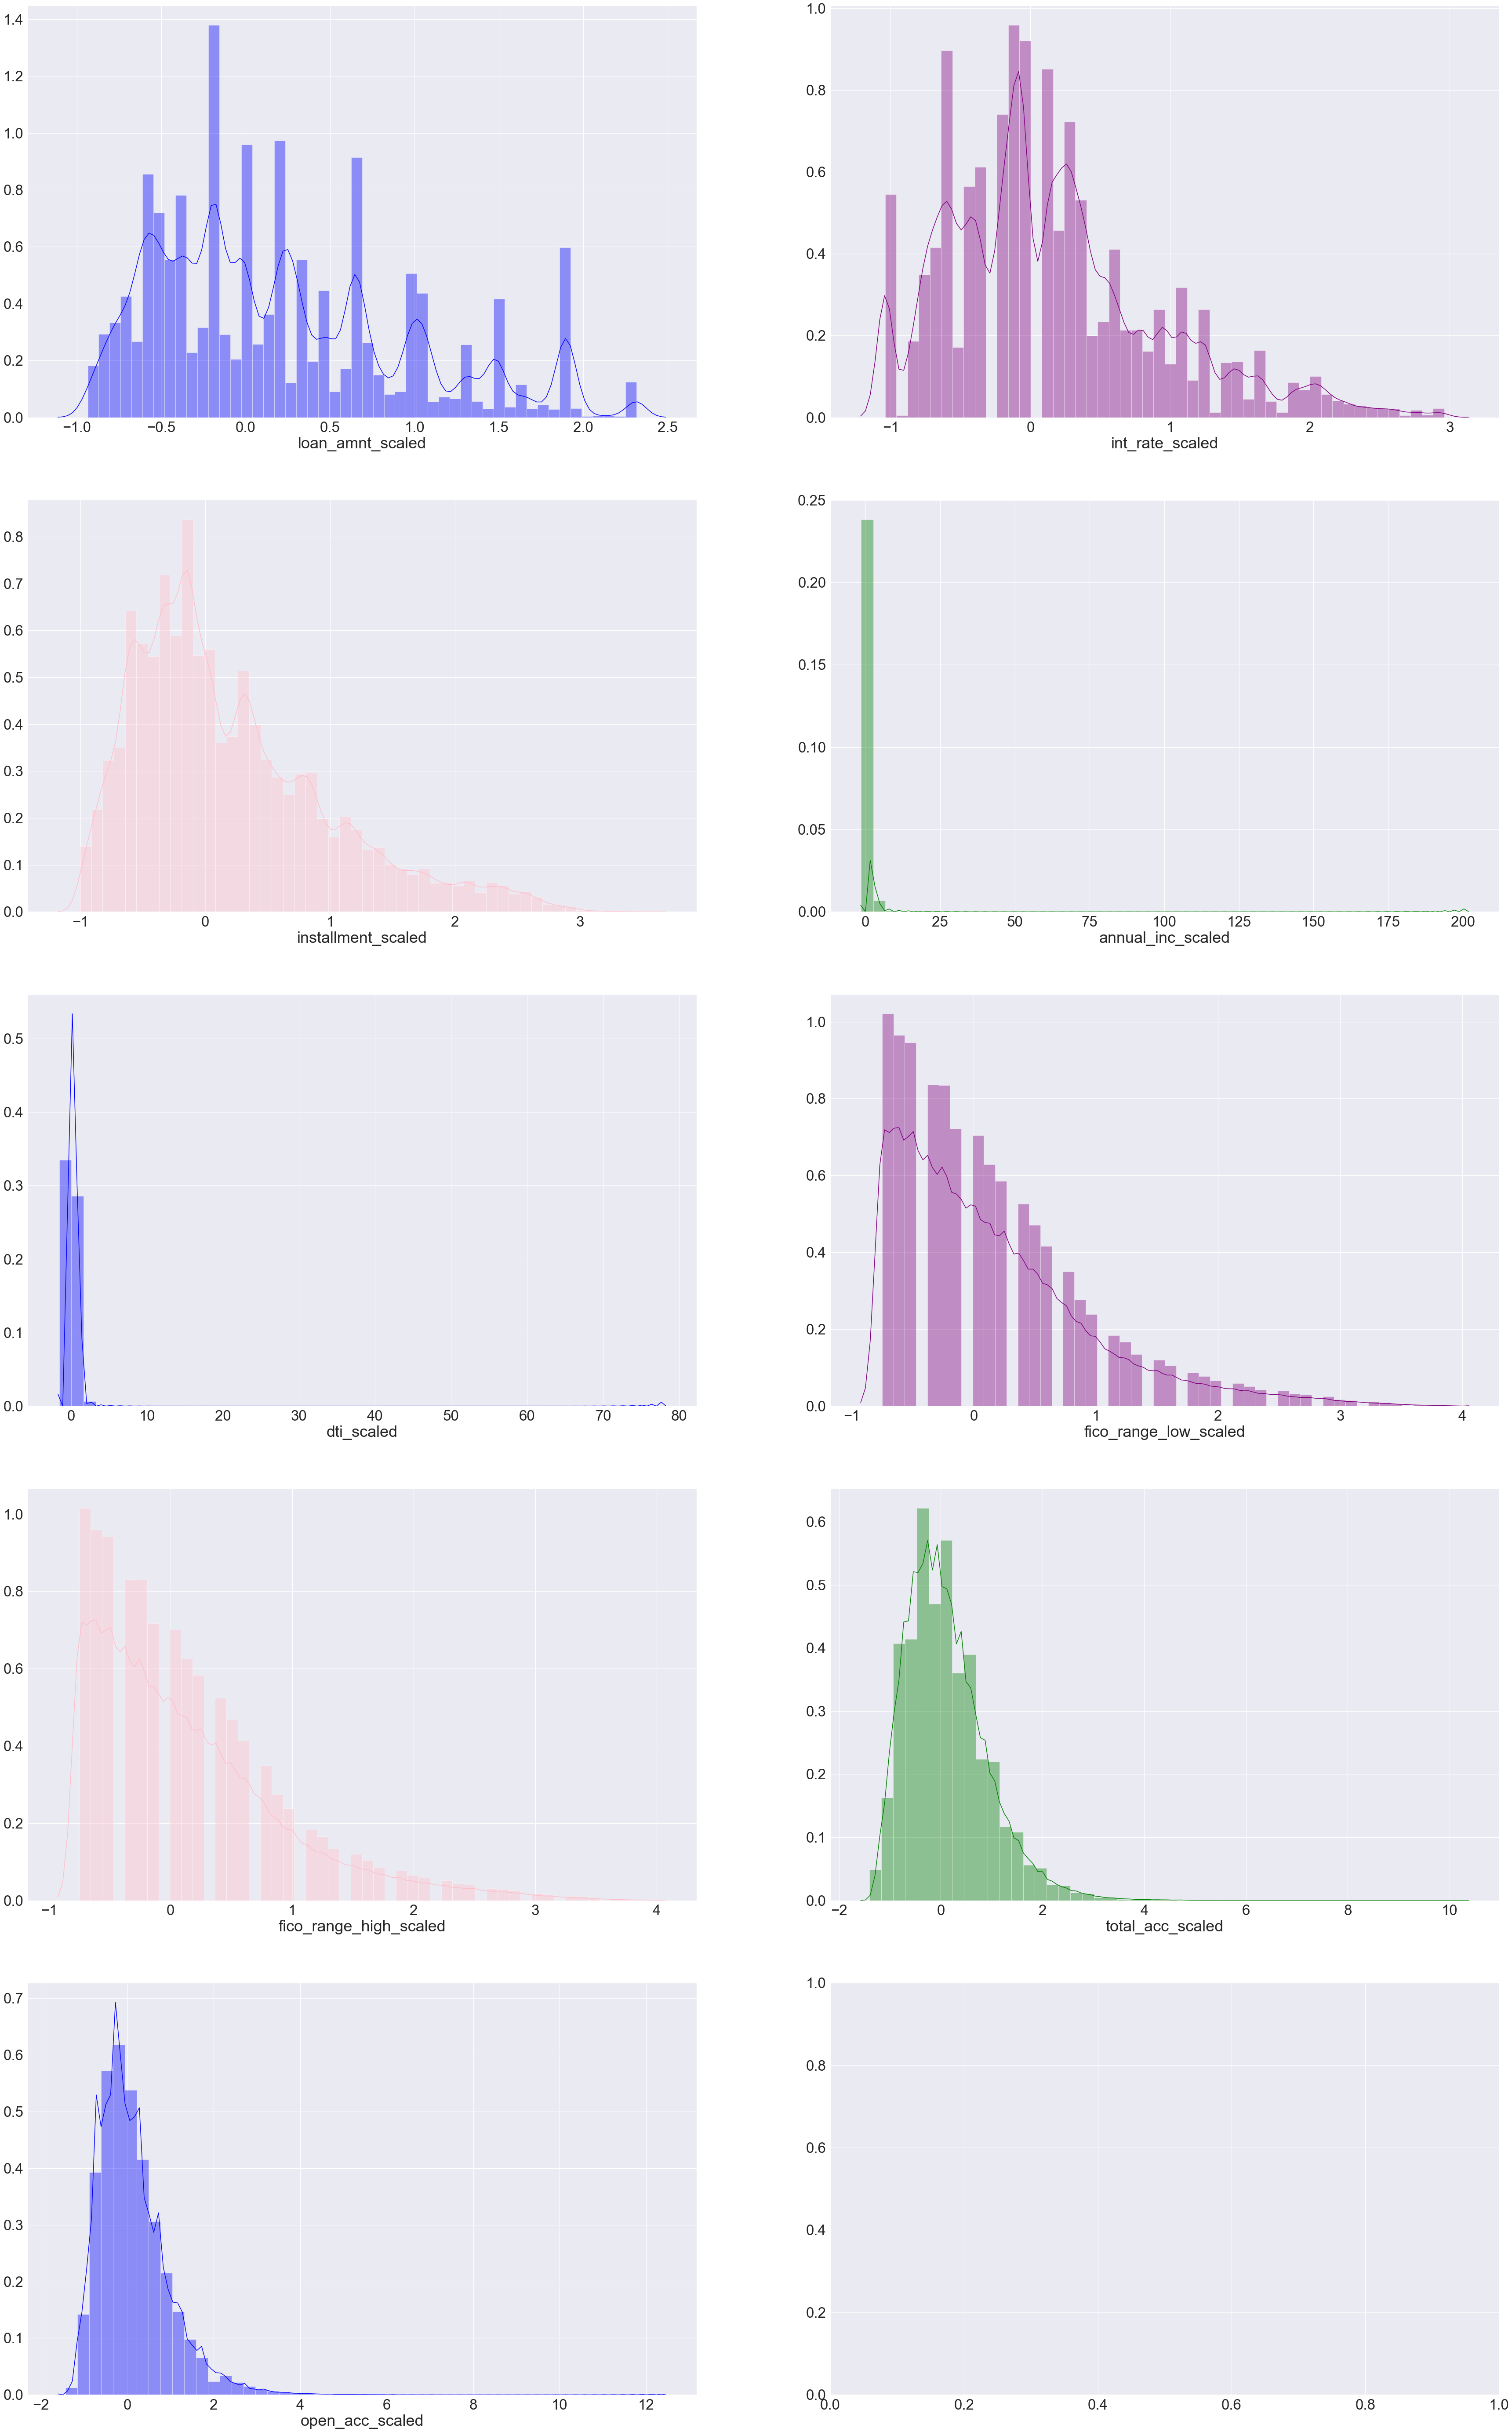

In [40]:
sns.set(font_scale=3)

n_numerics = len(scaled_num_features_list)
n_rows = int(n_numerics / 2) + (n_numerics % 2)
n_cols = 2

num_feature_count = 0
scaled_numerics_df = valid_features_df[scaled_num_features_list]

fig, axar = plt.subplots(ncols=n_cols, nrows= n_rows, figsize = (30 * n_cols , 20 * n_rows) )

colors = ['blue', 'purple' ,'pink', 'green']

for rw in range(n_rows):
    for cl in range(n_cols):
        if(num_feature_count < len(scaled_num_features_list)):
            sns.distplot(scaled_numerics_df.\
                         dropna(subset=[scaled_num_features_list[num_feature_count]])[scaled_num_features_list[num_feature_count]],\
                         ax = axar[rw][cl], kde=True, \
                         color = colors[int(num_feature_count % (len(colors)))])
            num_feature_count += 1

plt.show()

##### Observation:
Based on distributions of the scaled features above, features __annual_inc__ , __dti__, __fico_range__  (high/low), __total_acc__ and __open_acc__ require more normalizations, if possible. Here, I'm going to use log transformation on these features to see how it works:

In [41]:
valid_features_df['dti_logged'] = np.log(valid_features_df['dti']+1)
valid_features_df['annual_inc_logged'] = np.log(valid_features_df['annual_inc']+1)
valid_features_df['fico_range_low_logged'] = np.log(valid_features_df['fico_range_low']+1)
valid_features_df['fico_range_high_logged'] = np.log(valid_features_df['fico_range_high']+1)
valid_features_df['total_acc_logged'] = np.log(valid_features_df['total_acc']+1)
valid_features_df['open_acc_logged'] = np.log(valid_features_df['open_acc']+1)

In [42]:
# Checkkng if log transformation caused any null values:

valid_features_df['dti_logged'].isnull().sum(), \
valid_features_df['annual_inc_logged'].isnull().sum(),\
valid_features_df['fico_range_low_logged'].isnull().sum(),\
valid_features_df['fico_range_high_logged'].isnull().sum(),\
valid_features_df['total_acc_logged'].isnull().sum(),\
valid_features_df['open_acc_logged'].isnull().sum()

(63, 0, 0, 0, 0, 0)

In [43]:
# replacing null values with 0

valid_features_df['dti_logged'].fillna(0, inplace=True)

In [44]:
# Checking if log transformation caused any infinity values:

valid_features_df[np.isinf(valid_features_df['dti_logged'])]['dti_logged'] ,\
valid_features_df[np.isinf(valid_features_df['annual_inc_logged'])]['annual_inc_logged'],\
valid_features_df[np.isinf(valid_features_df['fico_range_low_logged'])]['fico_range_low_logged'],\
valid_features_df[np.isinf(valid_features_df['fico_range_high_logged'])]['fico_range_high_logged'],\
valid_features_df[np.isinf(valid_features_df['total_acc_logged'])]['total_acc_logged'],\
valid_features_df[np.isinf(valid_features_df['open_acc_logged'])]['open_acc_logged']


(1014615   -inf
 Name: dti_logged, dtype: float64,
 Series([], Name: annual_inc_logged, dtype: float64),
 Series([], Name: fico_range_low_logged, dtype: float64),
 Series([], Name: fico_range_high_logged, dtype: float64),
 Series([], Name: total_acc_logged, dtype: float64),
 Series([], Name: open_acc_logged, dtype: float64))

In [45]:
# removing the only infinity value caused by log transformation

valid_features_df.drop(index=1014615, inplace=True)

#### Logged Transformed Features Distributions

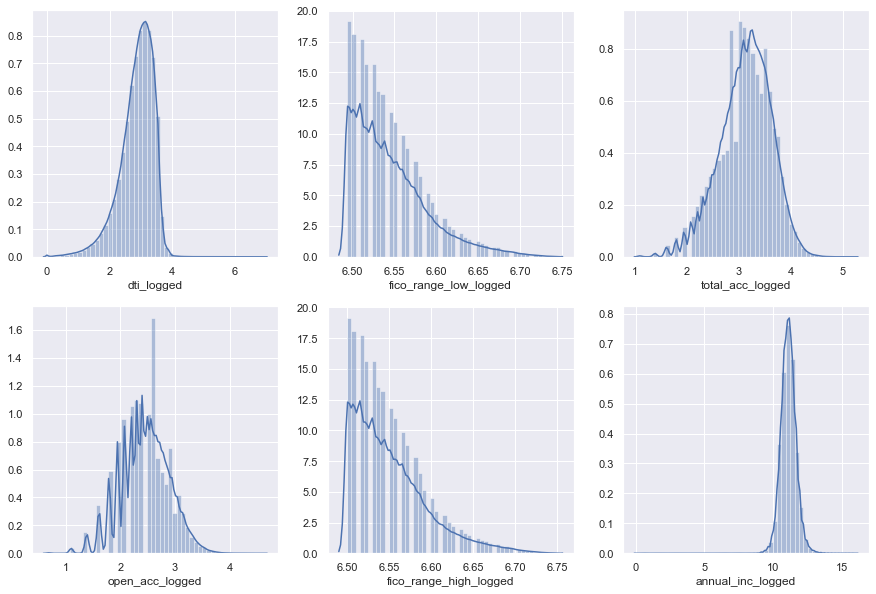

In [47]:
fig , axar = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
sns.set(font_scale=1)
sns.distplot(valid_features_df['dti_logged'], kde=True, ax=axar[0,0])
sns.distplot(valid_features_df['fico_range_low_logged'], kde=True, ax=axar[0,1])
sns.distplot(valid_features_df['total_acc_logged'], kde=True, ax=axar[0,2])
sns.distplot(valid_features_df['open_acc_logged'], kde=True, ax=axar[1,0])
sns.distplot(valid_features_df['fico_range_high_logged'], kde=True, ax=axar[1,1])
sns.distplot(valid_features_df['annual_inc_logged'], kde=True, ax=axar[1,2])

#### Observation:
Log transformations would give a better distribution (closer to normal) for dti, total_acc, open_acc, and annual_inc.
Therefore we're going to use logged_transform values of these features for modeling. However, log transformatinos didn't have sensible affects on fico_range_high and fico_range_low. Therefore, we're going to use the original scaled values for these two features. 

##### Scaling log-transformed features

In [48]:
valid_features_df['dti_logged_scaled'] = \
    rob_scaler.fit_transform(valid_features_df['dti_logged'].values.reshape(-1,1))
valid_features_df['total_acc_logged_scaled'] = \
    rob_scaler.fit_transform(valid_features_df['total_acc_logged'].values.reshape(-1,1))
valid_features_df['open_acc_logged_scaled'] = \
    rob_scaler.fit_transform(valid_features_df['open_acc_logged'].values.reshape(-1,1))
valid_features_df['anl_inc_logged_scaled'] = \
    rob_scaler.fit_transform(valid_features_df['annual_inc_logged'].values.reshape(-1,1))

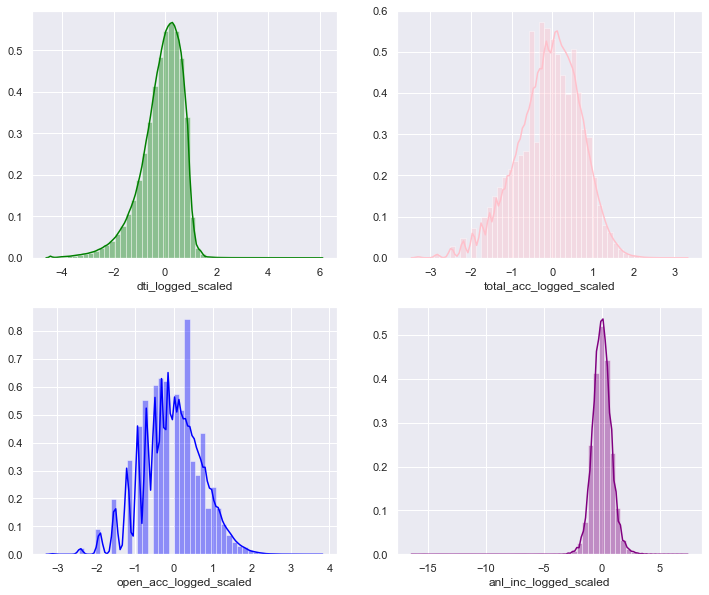

In [49]:
fig , axar = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
sns.distplot(valid_features_df['dti_logged_scaled'], kde=True, ax=axar[0,0], color = 'green')
sns.distplot(valid_features_df['total_acc_logged_scaled'], kde=True, ax=axar[0,1], color='pink')
sns.distplot(valid_features_df['open_acc_logged_scaled'], kde=True, ax=axar[1,0], color='blue')
sns.distplot(valid_features_df['anl_inc_logged_scaled'], kde=True, ax=axar[1,1], color='purple')

##### Here is the final list of scaled/normalized numeric features to be used for model training:

In [52]:
transformed_num_features = ['loan_amnt_scaled','installment_scaled','int_rate_scaled','anl_inc_logged_scaled',\
                            'dti_logged_scaled', 'fico_range_low_scaled','fico_range_high_scaled', \
                            'total_acc_logged_scaled', 'open_acc_logged_scaled']

#### Correlation Matrix

Text(0.5, 1, 'Correlation for the whole (imbalanced) dataset')

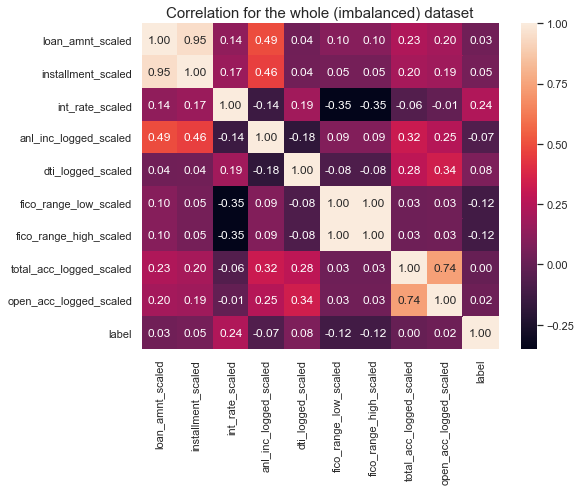

In [53]:
sns.set(font_scale=1)
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
df_corr = valid_features_df[transformed_num_features+['label']].corr()
sns.heatmap(df_corr, cbar=True, annot=True ,fmt='.2f', ax=ax)
ax.set_title("Correlation for the whole (imbalanced) dataset", fontsize=15)

##### Observations:
* Loan amount (loan_amnt_scaled) and installment amount (installmend_scaled) are very highly correlated (0.95)
* fico_range_low_scaled and fico_range_high_scaled seem to be equal (correlation of 1)
* As a result, features installment_scaled and fico_range_high_scaled can be removed from the feature space
* After removing the 2 features mentioned above, most the remaining features are not highly correlated, and considering the low number of numeric features, there seems no need to use dimentionality reduction techniques, and we can go ahead and use these features for model training

In [54]:
transformed_num_features.remove("installment_scaled")
transformed_num_features.remove("fico_range_high_scaled")

Updated list of numeric features:

In [55]:
transformed_num_features

['loan_amnt_scaled',
 'int_rate_scaled',
 'anl_inc_logged_scaled',
 'dti_logged_scaled',
 'fico_range_low_scaled',
 'total_acc_logged_scaled',
 'open_acc_logged_scaled']

### Removing Outliers

It's always nice to observe the distribution breakdown by target label for each numeric feature using box plots, to have a better insights about what feature to use for outlier removal.

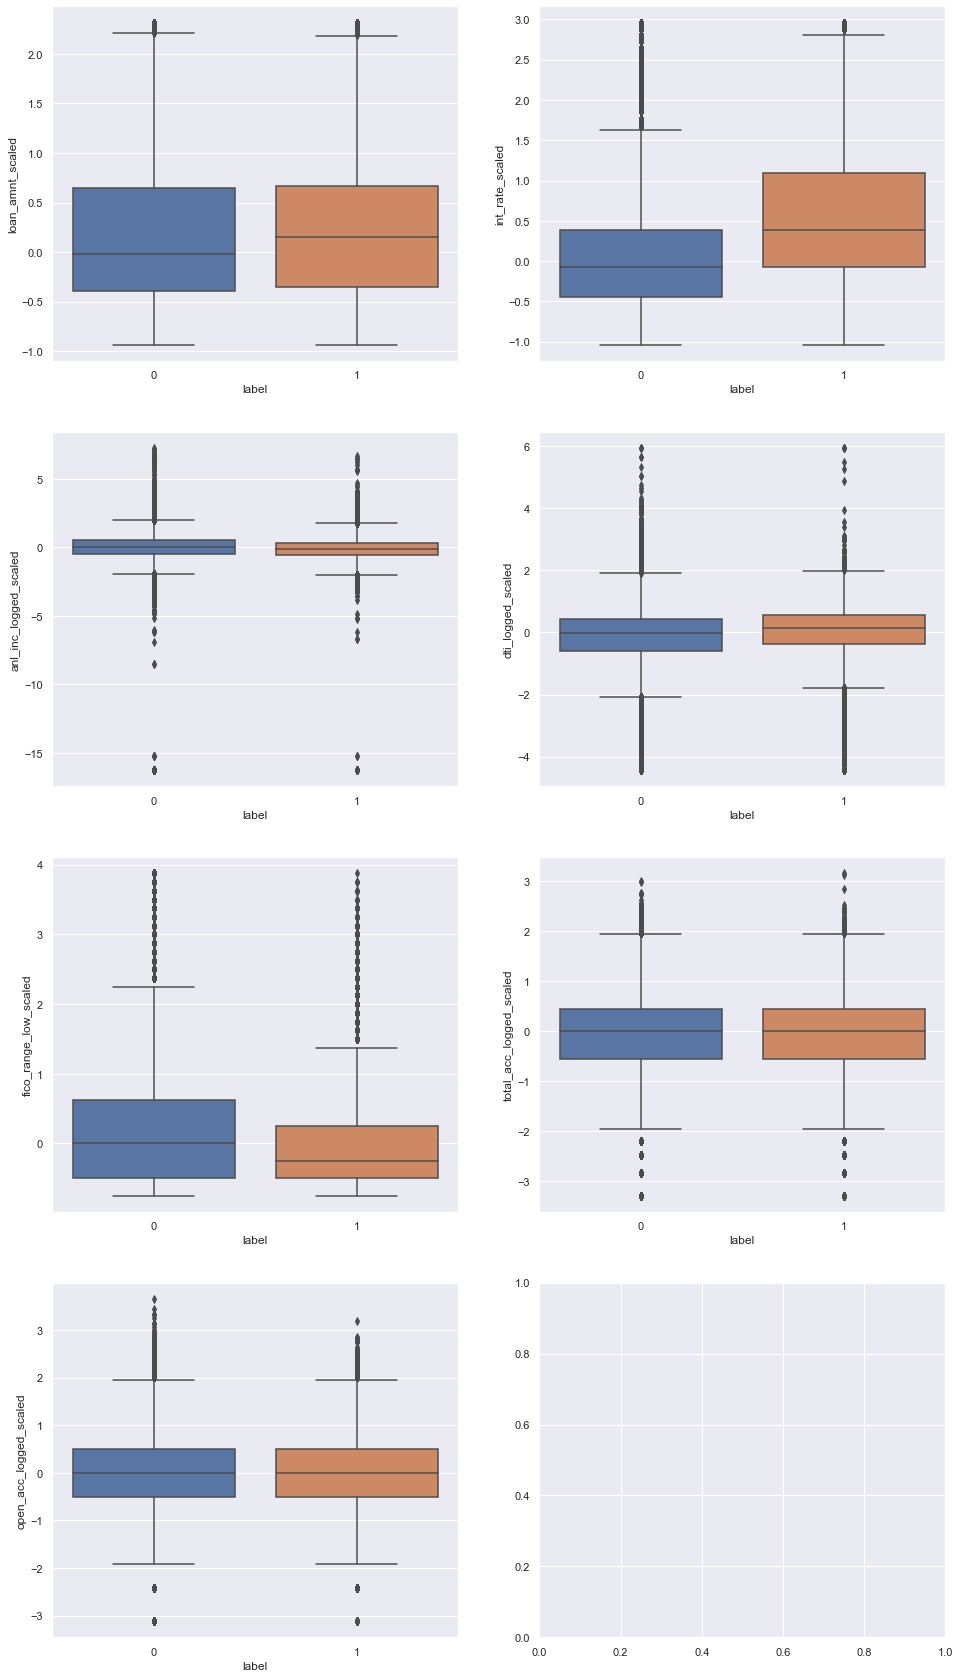

In [59]:
fig , axar = plt.subplots(nrows=4, ncols=2, figsize=(16,30))

sns.set(font_scale=1)

vc = 0

for i in range(len(axar)):
    for j in range(len(axar[0])):
        if vc < len(transformed_num_features):
            sns.boxplot(x='label', y=transformed_num_features[vc], data=valid_features_df, ax=axar[i,j])
            vc+=1
                   

#### Observation:
* Loan amount, interest rate and fico range are showing good discriminative power based on box plots, therefore I don't consider these variables for outlier removal.
* Annual income and dti (debt-to-income) ratio can be two good candidate to be a base for outlier removal:
    * These features, are in nature and intuitively critical towards the final status of the loan. Removing outliers based on these two features might gain more discriminative power to these two features, and potential guiding the model to see a lower risk for higher income / lower dti and higher risk for lower income/higher dti.
    * Unexpectedly very low and very high income applicants, are relatively rare, and their applications have to be analysed case by case. 

In [60]:
def outlier_remover(df, var_list, cut_off_tr = 1.5):
    new_df = df
    for v in var_list:
        values = df[v].values
        q25, q75 = np.percentile(values, 25), np.percentile(values, 75)
        v_iqr = q75 - q25
        v_lower , v_upper = q25 - (v_iqr * cut_off_tr) , q75 + (v_iqr * cut_off_tr)
        new_df = new_df.drop(new_df[(new_df[v] > v_upper) | (new_df[v] < v_lower)].index)
    outlier_count = len(df) - len(new_df)
    return outlier_count,new_df

In [84]:
var_list = ['anl_inc_logged_scaled','dti_logged_scaled']
outlier_count_pos , outlier_free_pos = outlier_remover(valid_features_df.query('label == 1'), var_list)
outlier_count_neg , outlier_free_neg = outlier_remover(valid_features_df.query('label == 0'), var_list)

In [85]:
outlier_count_neg, outlier_count_pos, \
len(valid_features_df.query("label == 0")) , len(valid_features_df.query("label==1"))

(16632, 3644, 358913, 68242)

In [86]:
featureset= pd.concat([outlier_free_pos, outlier_free_neg])

#### Observing transformed anual_income and dti features after outlier removal

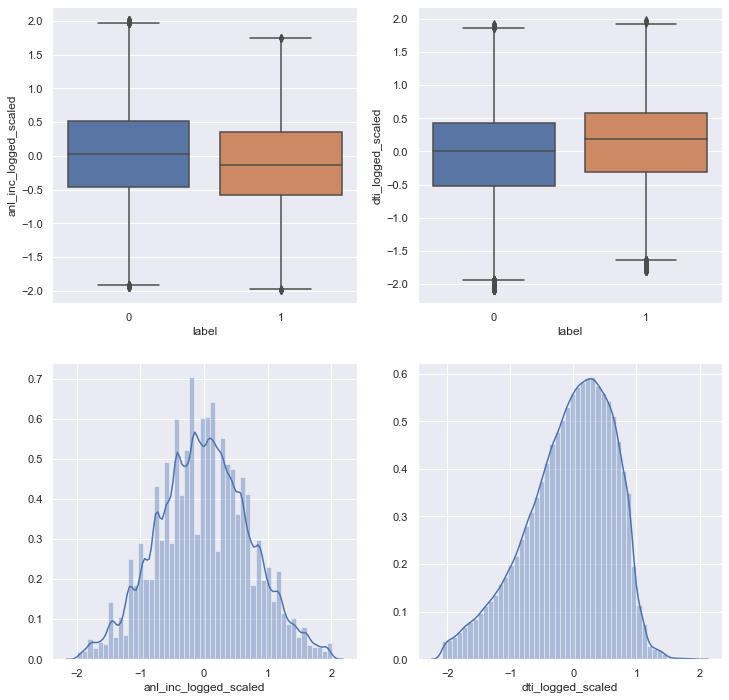

In [89]:
fig , ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
sns.boxplot(x='label', y='anl_inc_logged_scaled', data=featureset, ax=ax[0,0])
sns.boxplot(x='label', y='dti_logged_scaled', data=featureset, ax=ax[0,1])
sns.distplot(featureset['anl_inc_logged_scaled'], kde=True, ax=ax[1,0])
sns.distplot(featureset['dti_logged_scaled'], kde=True, ax=ax[1,1])


#### Creating a Balanced Dataset
Here, I'm going to create a balance dataset in which the number of instances for each label(0 and 1) are equal. This is necessary for the following reasons:
* Analysis of the categorical features: In order to assess the discriminative power of each categorical feature, we need a randomly sampled data set in which there are equal numbers of instances for each label.
* Model (classifier) training: Classifier models are normally trained better on a balanced dataset.

In [90]:
len(featureset.query("label == 1"))

64598

In [93]:
label_0_sample = featureset.query("label==0").sample(n=65000)
label_1_sample = featureset.query("label==1")
balanced_featureset= pd.concat([label_0_sample, label_1_sample])

Text(0.5, 1, 'Correlation for the balanced dataset')

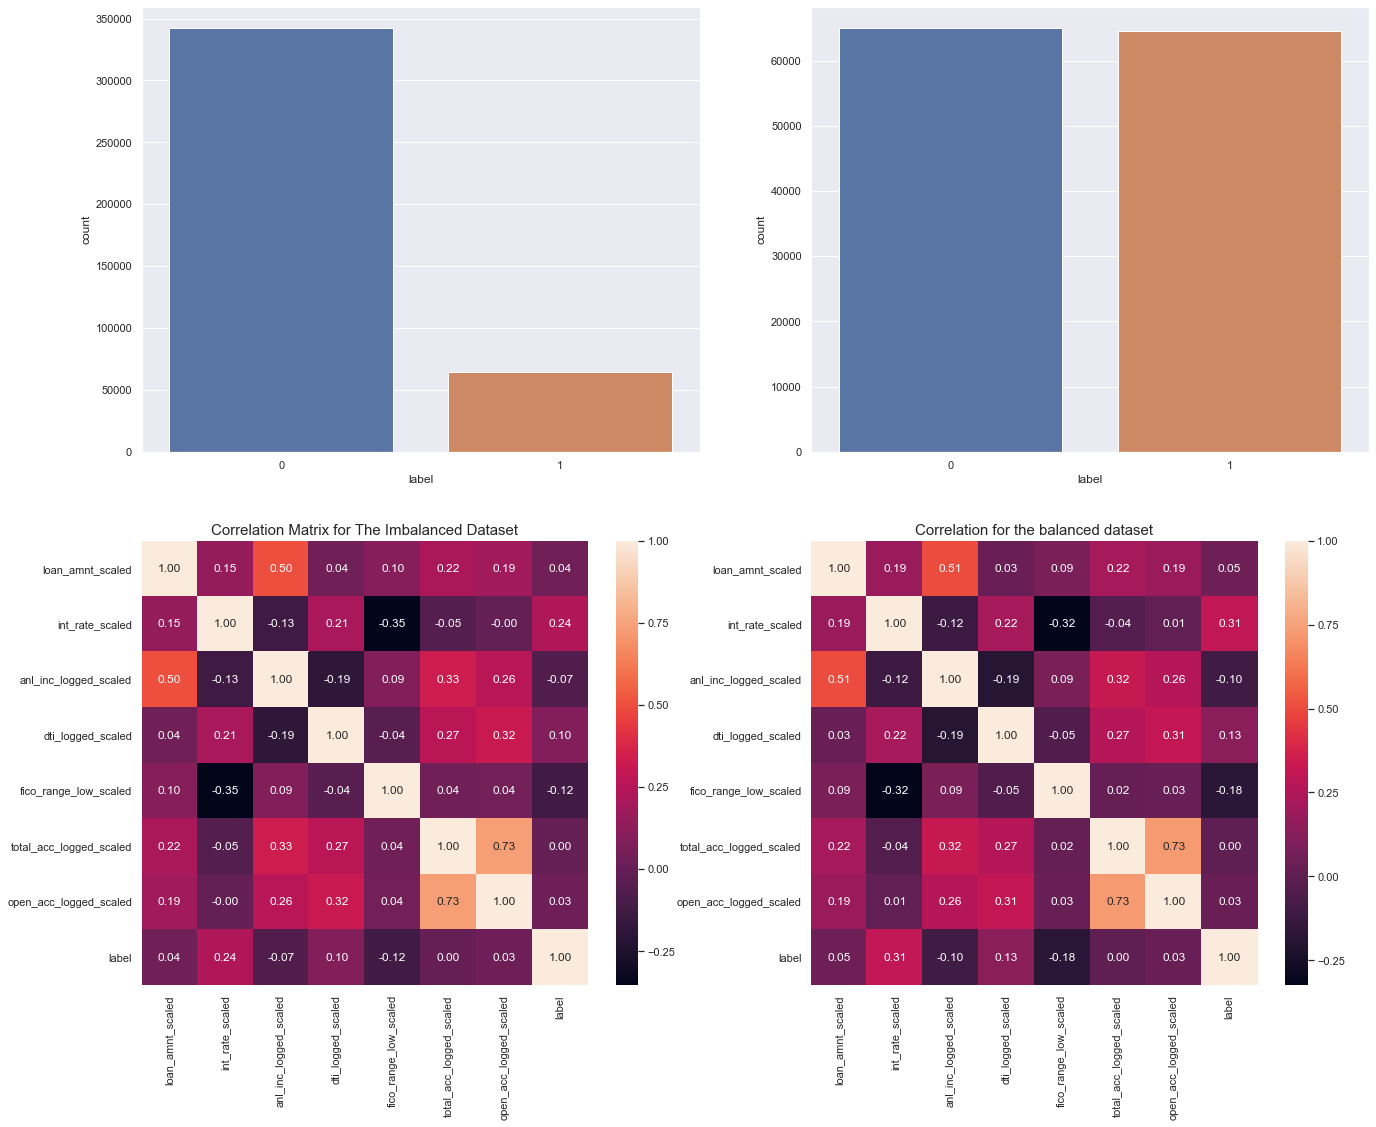

In [102]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,18))
sns.countplot('label', data = featureset, ax=ax[0,0])
sns.countplot('label', data = balanced_featureset, ax=ax[0,1])

df_corr = featureset[transformed_num_features+['label']].corr()
sns.heatmap(df_corr, cbar=True, annot=True ,fmt='.2f', ax=ax[1,0])
ax[1,0].set_title("Correlation Matrix for The Imbalanced Dataset", fontsize=15)

df_corr = balanced_featureset[transformed_num_features+['label']].corr()
sns.heatmap(df_corr, cbar=True, annot=True ,fmt='.2f', ax=ax[1,1])
ax[1,1].set_title("Correlation for the balanced dataset", fontsize=15)

### Analysis of The Categorical Features

In this section, I'm going to the followings:
* Assessing the potential link between each categorical feature and the target label feature
* Creating new numeric features that will represent categorical features (converting cat feature to num feature). 

In [232]:
cats

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'title',
 'initial_list_status',
 'application_type']

In [104]:
#I'm keeping the new numeric/binary features representing categorical features in this set:

new_features = set()

##### Term (36 months vs 60 months)

In [105]:
balanced_featureset['term'].value_counts(dropna=False)

 36 months    92413
 60 months    37185
Name: term, dtype: int64

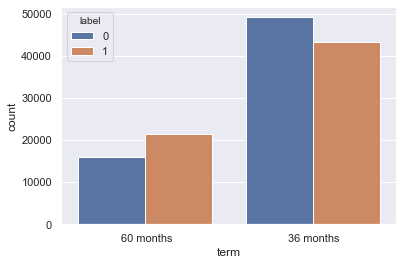

In [106]:
sns.countplot(balanced_featureset['term'], hue=featureset['label'])

__Intuition__ : Long term (60 months) loans are more likely to become charge-off compared to short term (36 months) loans.

In [107]:
# Creating a numeric binary feature for term:

def get_term(row):
    if "36" in row['term']:
        return 0
    elif "60" in row['term']:
        return 1
    
balanced_featureset['term_bin'] = balanced_featureset.apply(lambda r: get_term(r), axis=1)

new_features.add("term_bin")

In [108]:
balanced_featureset[['term','term_bin']].sample(10)

,term,term_bin
1992609,36 months,0
692719,36 months,0
2157272,36 months,0
2183193,36 months,0
1022745,36 months,0
1058566,60 months,1
708669,60 months,1
2001671,36 months,0
666757,36 months,0
682677,36 months,0


#### Grade (A, B, C, D, E, F, G)

In [109]:
balanced_featureset['grade'].value_counts(dropna=False)

C    40798
B    34954
D    21672
A    15384
E    10860
F     4595
G     1335
Name: grade, dtype: int64

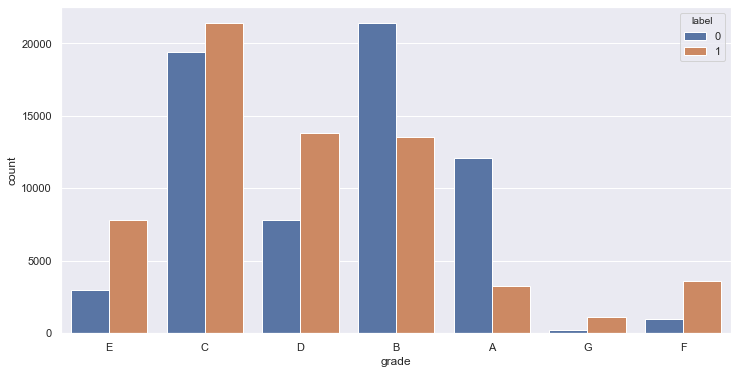

In [110]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
sns.countplot(balanced_featureset['grade'], hue=balanced_featureset['label'], ax=ax)

__Intuition__: As can be expected, the better the grade, the lower liklihood of charge-off

In [111]:
# Creating a new numeric feature for Grade:
"""
Grades:
A -> 1
B -> 0.85
C -> 0.70
D -> 0.55
E -> 0.40
F -> 0.25
G -> 0.10
"""

def get_grade(row):
    grd = row["grade"]
    if grd=='A':
        return 1.0
    elif grd=='B':
        return 0.85
    elif grd=='C':
        return 0.70
    elif grd=='D':
        return 0.55
    elif grd=='E':
        return 0.40
    elif grd=="F":
        return 0.25
    elif grd=="G":
        return 0.10
    else:
        return 0

balanced_featureset["grade_num"] = balanced_featureset.apply(lambda r: get_grade(r), axis=1)

new_features.add("grade_num")

In [112]:
balanced_featureset[['grade', 'grade_num']].head(10)

,grade,grade_num
1950698,E,0.40
2243308,C,0.70
2201618,D,0.55
678565,B,0.85
1940139,C,0.70
2217249,C,0.70
718198,D,0.55
2231959,B,0.85
2220723,A,1.00
1075806,C,0.70


#### Home Ownership

In [113]:
balanced_featureset['home_ownership'].value_counts(dropna=False)

MORTGAGE    59547
RENT        54448
OWN         15573
ANY            30
Name: home_ownership, dtype: int64

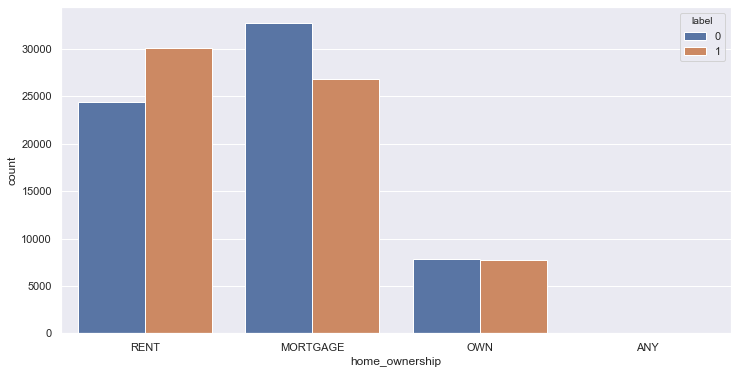

In [114]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
sns.countplot(balanced_featureset['home_ownership'], hue=balanced_featureset['label'], ax=ax)

__Intuition__: Renters are more likely to charge-off compared to home owners!

In [115]:
#Creating a new numeric binary feature for home ownership

def get_home_ownership(row):
    if row['home_ownership']=="MORTGAGE" or row['home_ownership']=="OWN":
        return 1
    else:
        return 0


balanced_featureset['home_ownership_bin'] = balanced_featureset.apply(lambda r: get_home_ownership(r), axis=1)

new_features.add("home_ownership_bin")

In [116]:
balanced_featureset[['home_ownership','home_ownership_bin']].sample(10)

,home_ownership,home_ownership_bin
1042929,RENT,0
2213193,MORTGAGE,1
1097772,MORTGAGE,1
997825,RENT,0
1046158,MORTGAGE,1
1105465,MORTGAGE,1
2201197,MORTGAGE,1
1079894,OWN,1
1082556,MORTGAGE,1
671076,RENT,0


#### Employment Length

In [117]:
balanced_featureset['emp_length'].value_counts(dropna=False)

10+ years    43589
2 years      11929
3 years      10577
< 1 year      9624
1 year        9019
NaN           8925
5 years       7945
4 years       7646
8 years       5622
6 years       5543
9 years       4969
7 years       4210
Name: emp_length, dtype: int64

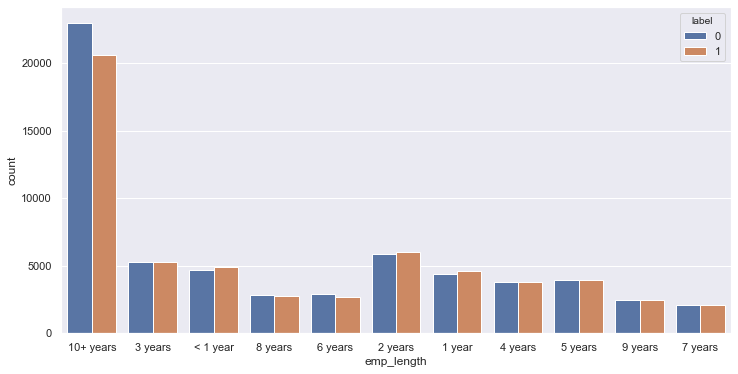

In [118]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
sns.countplot(balanced_featureset['emp_length'], hue=balanced_featureset['label'], ax=ax)

In [119]:
# Creating a new numeric valriable for employment length

def get_emp_length(row):
    empl = row["emp_length"]
    if "1 year" in empl:
        return 1
    elif empl=='2 years':
        return 2
    elif empl=='3 years':
        return 3
    elif empl=='4 years':
        return 4
    elif empl=='5 years':
        return 5
    elif empl=='6 years':
        return 6
    elif empl=='7 years':
        return 7
    elif empl=='8 years':
        return 8
    elif empl=='9 years':
        return 9
    elif empl=='10+ years':
        return 10
    return 0

balanced_featureset['emp_length'].fillna("0", inplace=True)
balanced_featureset['emp_length_num'] = balanced_featureset.apply(lambda r: get_emp_length(r), axis=1)
balanced_featureset['emp_length_num_scaled'] = \
    rob_scaler.fit_transform(balanced_featureset['emp_length_num'].values.reshape(-1,1))

new_features.add("emp_length_num_scaled")

In [120]:
balanced_featureset[['emp_length','emp_length_num','emp_length_num_scaled']].sample(5)

,emp_length,emp_length_num,emp_length_num_scaled
1028623,3 years,3,-0.250
704118,2 years,2,-0.375
724806,0,0,-0.625
2255175,5 years,5,0.000
652387,10+ years,10,0.625


#### Verification Status

In [121]:
balanced_featureset['verification_status'].value_counts(dropna=False)

Source Verified    53760
Verified           41462
Not Verified       34376
Name: verification_status, dtype: int64

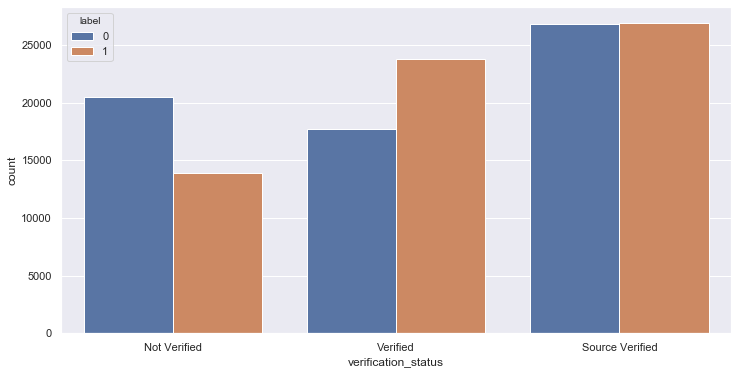

In [122]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
sns.countplot(balanced_featureset['verification_status'], hue=balanced_featureset['label'], ax=ax)

In [123]:
# Creating a new numeric binary feature for verification status

def get_ver_status(row):
    if "Not" in row['verification_status']:
        return 0
    else:
        return 1
    
balanced_featureset['ver_stat_bin'] = balanced_featureset.apply(lambda r: get_ver_status(r), axis =1)

new_features.add('ver_stat_bin')

In [124]:
balanced_featureset[['verification_status', 'ver_stat_bin']].sample(7)

,verification_status,ver_stat_bin
1024763,Not Verified,0
672653,Verified,1
1059255,Not Verified,0
743645,Verified,1
738155,Not Verified,0
1074100,Not Verified,0
700481,Source Verified,1


#### Loan Purpose

In [125]:
balanced_featureset['purpose'].value_counts(dropna=False)

debt_consolidation    76924
credit_card           26003
home_improvement       8386
other                  8274
major_purchase         2860
medical                1677
small_business         1516
car                    1261
moving                 1002
vacation                947
house                   654
renewable_energy         93
wedding                   1
Name: purpose, dtype: int64

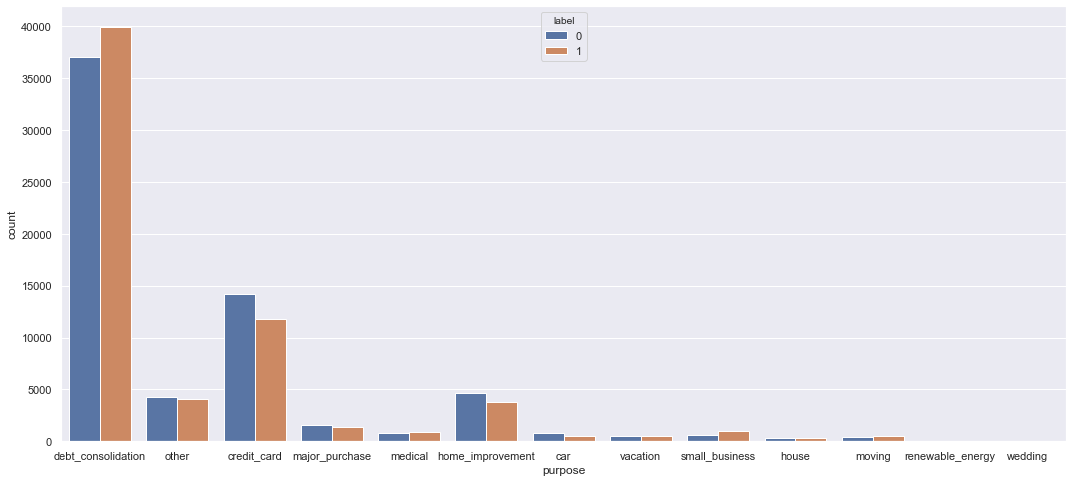

In [126]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(18,8))
sns.countplot(balanced_featureset['purpose'], hue=balanced_featureset['label'], ax=ax)

Evidence suggests that debt_consolidation purpose has a higher risk of charge-off, despite all other categories. Based on this observation (see the diagram above), I'm just going a new numeric binary feature, indiciating wether the purpose of the loan is debt_consolidation or not:

In [127]:
def debt_cons(row):
    if row['purpose'] == "debt_consolidation":
        return 1
    else:
        return 0

balanced_featureset['debt_cons_purpose'] = balanced_featureset.apply(lambda row : debt_cons(row), axis=1)

new_features.add('debt_cons_purpose')

In [128]:
balanced_featureset[['debt_cons_purpose','purpose']].sample(10)

,debt_cons_purpose,purpose
1059188,0,credit_card
731891,0,home_improvement
709898,1,debt_consolidation
2002265,0,home_improvement
703819,1,debt_consolidation
1084676,1,debt_consolidation
1997735,1,debt_consolidation
2038289,0,credit_card
749051,0,other
2190664,1,debt_consolidation


#### Initial list Status

In [129]:
balanced_featureset['initial_list_status'].value_counts(dropna=False)

w    97859
f    31739
Name: initial_list_status, dtype: int64

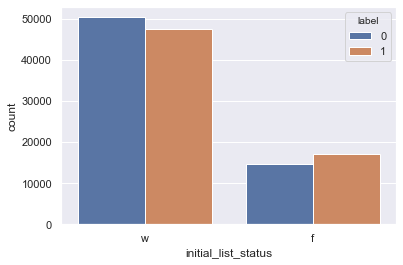

In [130]:
sns.countplot(balanced_featureset['initial_list_status'], hue=balanced_featureset['label'])

In [132]:
def initial_stats(row):
    if row['initial_list_status']=='f':
        return 1
    elif row['initial_list_status']=='w':
        return 0
    
balanced_featureset['initial_list_stat_bin'] = \
    balanced_featureset.apply(lambda row : initial_stats(row), axis=1)

new_features.add('initial_list_stat_bin')

In [133]:
balanced_featureset[['initial_list_status','initial_list_stat_bin']].sample(5)

,initial_list_status,initial_list_stat_bin
2218376,w,0
1028231,w,0
722921,f,1
1963060,w,0
1026664,w,0


#### Application Type (Joint / Individual)

In [134]:
balanced_featureset['application_type'].value_counts(dropna=False)

Individual    127098
Joint App       2500
Name: application_type, dtype: int64

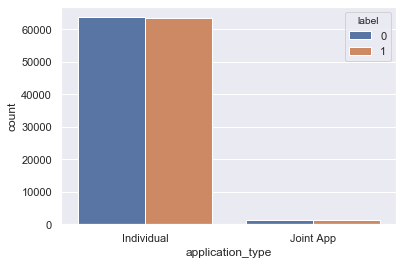

In [135]:
sns.countplot(balanced_featureset['application_type'], hue=balanced_featureset['label'])

This feature (app_type) is very imbalanced. I'm ignoring this feature for now.

#### Finalizing The Feature Set for Machine Learning

In [152]:
ml_featureset = balanced_featureset[transformed_num_features+list(new_features)+['label']]

In [153]:
ml_featureset.head()

,loan_amnt_scaled,int_rate_scaled,anl_inc_logged_scaled,dti_logged_scaled,fico_range_low_scaled,total_acc_logged_scaled,open_acc_logged_scaled,home_ownership_bin,ver_stat_bin,term_bin,emp_length_num_scaled,grade_num,initial_list_stat_bin,debt_cons_purpose,label
1950698,0.647917,2.024922,1.320184,-0.408592,1.000,-0.137562,-0.151228,0,0,1,0.625,0.40,0,1,0
2243308,2.314583,0.560748,0.259763,-0.118876,0.750,-0.369338,-0.704710,1,1,1,-0.250,0.70,1,1,0
2201618,-0.143750,1.479751,0.432295,-0.035648,0.750,-0.852138,-0.316880,0,0,1,-0.500,0.55,0,0,0
678565,0.231250,-0.080997,-0.583042,0.416473,0.250,-0.852138,-0.151228,0,1,0,-0.500,0.85,1,1,0
1940139,0.731250,0.389408,-0.161640,-0.283468,1.125,0.503466,0.500000,1,0,1,0.625,0.70,0,0,0


In [154]:
len(ml_featureset)

129598

### Visual Evidence About Class (0/1) Difference Using Dementionality Reduction

In [231]:
from sklearn.decomposition import PCA,KernelPCA, TruncatedSVD
from sklearn.manifold import TSNE
data_pca = ml_featureset.sample(10000)
X = data_pca.drop('label', axis=1)
y = data_pca['label']

pca_model = PCA(n_components=2, random_state=42)

X_reduced_PCA = pca_model.fit_transform(X)

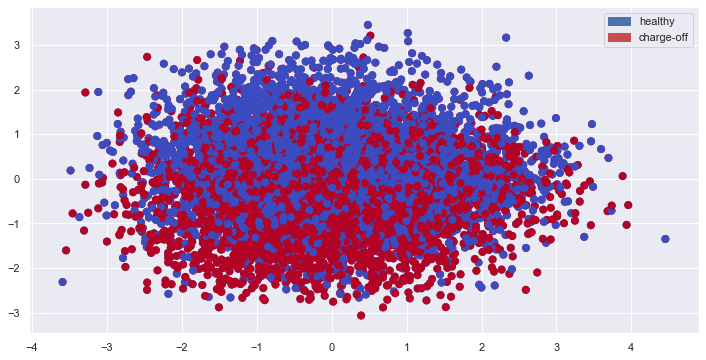

In [232]:
import matplotlib.patches as mpatches

blue_patch = mpatches.Patch(color='b', label='healthy')
red_patch = mpatches.Patch(color='r', label='charge-off')


f , ax = plt.subplots(1, 1, figsize=(12,6))
ax.scatter(X_reduced_PCA[:,0], X_reduced_PCA[:,1], c=(y==0), label='healthy', cmap='coolwarm', linewidth=2)
ax.scatter(X_reduced_PCA[:,0], X_reduced_PCA[:,1], c=(y==1), label='charge-off', cmap='coolwarm', linewidth=2)
ax.legend(handles=[blue_patch, red_patch])
plt.show()

In [237]:
pca_model.explained_variance_ratio_

array([0.24165115, 0.18235611])

### Modeling (1): Logistic Regression

In [158]:
X = ml_featureset[transformed_num_features + list(new_features)]
y = ml_featureset['label']

In [159]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [163]:
from sklearn.model_selection import GridSearchCV
lr_params= {"penalty" :["l1","l2"], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_lr = GridSearchCV(LogisticRegression(), lr_params, scoring='roc_auc', cv=5)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [164]:
grid_lr.best_score_

0.6419329320077186

In [165]:
best_lr = grid_lr.best_estimator_

In [166]:
pd.concat([pd.DataFrame(X_train.columns, columns=['variables']) ,\
           pd.DataFrame(best_lr.coef_[0] , columns=['correlations'])], axis=1).\
           sort_values(by ='correlations', ascending=False)

,variables,correlations
1,int_rate_scaled,0.628006
3,dti_logged_scaled,0.143914
6,open_acc_logged_scaled,0.014771
0,loan_amnt_scaled,0.000000
5,total_acc_logged_scaled,0.000000
8,ver_stat_bin,0.000000
9,term_bin,0.000000
10,emp_length_num_scaled,0.000000
12,initial_list_stat_bin,0.000000
13,debt_cons_purpose,0.000000


In [190]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, \
                        train_sizes=np.linspace(0.1, 1.0, 5), figsize=None):
    if figsize is None:
        plt.figure()
    else:
        plt.figure(figsize = figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Instances")
    plt.ylabel("Score")
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, \
                                                           cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,\
                                                           scoring="roc_auc")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, \
                     train_scores_mean+train_scores_std, alpha=0.1, color="g")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, \
                     val_scores_mean + val_scores_std, alpha=0.1 , color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/koosha.tahmasebipour/anaconda3/envs/kaggle/lib/python3.7/site-packages/matplotlib/pyplot.py'>

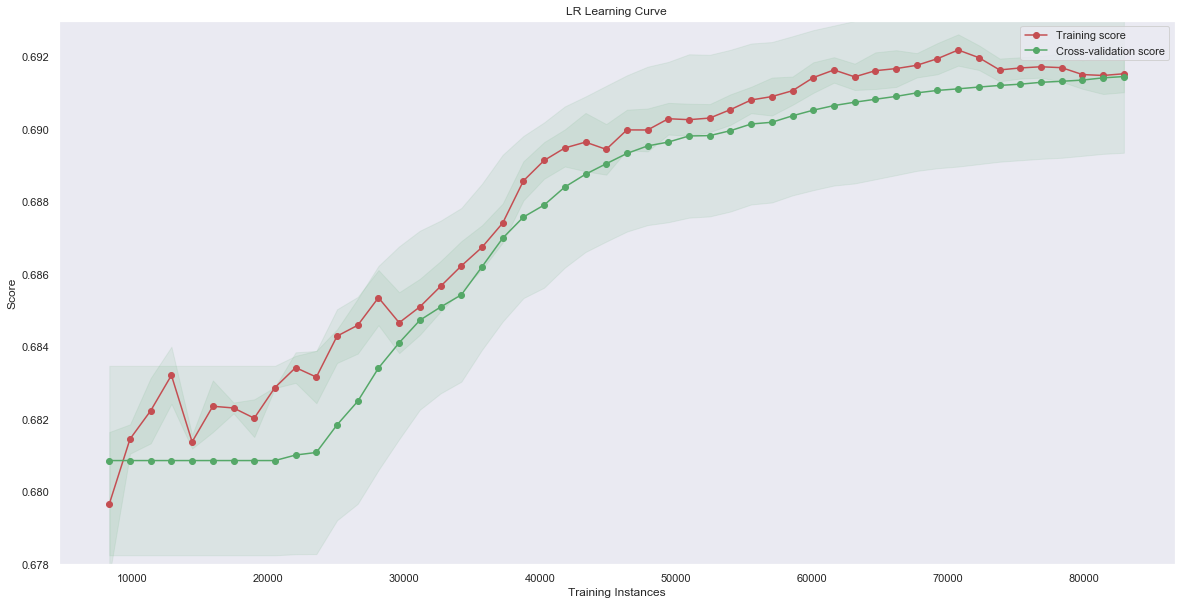

In [200]:
plot_learning_curve(best_lr, "LR Learning Curve", X_train, y_train, ylim=(0.678,0.693) ,cv=5, n_jobs=4, \
                    train_sizes=np.linspace(0.1,1.0,50), figsize=(20,10))

#### Observations of LR results:
The LR model performance is not quite as expected (~0.64 roc-auc score). As LR feature importance table suggests, the LR model has become too dependent to a smaller fraction of the features, and it has 0 dependency to most of the features. This can also explains the behavior that can be seen in the model learning curve. Normally, when the model becomes too much dependent to a small fraction of features, the training and cross validation curves get twisted to one another and follow the more-or-less the same curve path in the learning curve diagram.

### Modeling (2): Random Forest 

In [201]:
from sklearn.ensemble import RandomForestClassifier
rf_base = RandomForestClassifier(n_jobs=-1, max_depth=3)
rf_param_grid = {"n_estimators":[100,200,300,500,1000], "criterion":['gini','entropy']}
gs_rf = GridSearchCV(estimator=rf_base, param_grid=rf_param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=10)
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:  1.3min remaining:   38.7s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:  1.4min remaining:   23.2s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:  1.7min remaining:   11.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=3,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='war

In [202]:
gs_rf.best_score_

0.6347537568240128

In [203]:
gs_rf.best_params_

{'criterion': 'entropy', 'n_estimators': 100}

In [204]:
rf_best = gs_rf.best_estimator_

<module 'matplotlib.pyplot' from '/Users/koosha.tahmasebipour/anaconda3/envs/kaggle/lib/python3.7/site-packages/matplotlib/pyplot.py'>

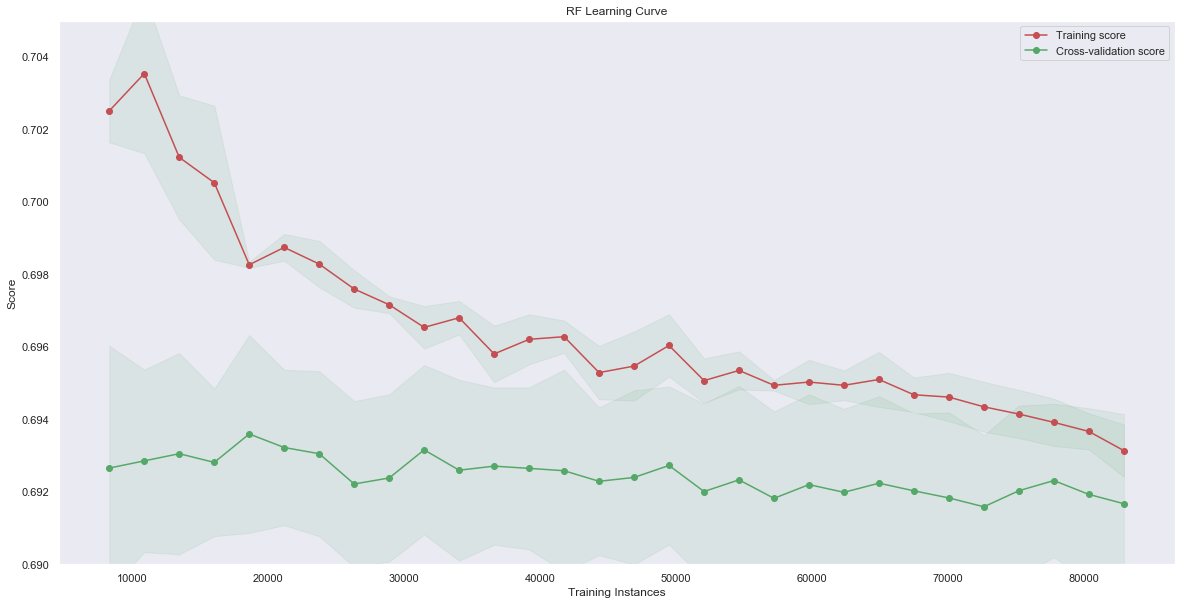

In [209]:
plot_learning_curve(rf_best, "RF Learning Curve", X_train, y_train, ylim=(0.690,0.705) ,cv=5, n_jobs=-1, \
                    train_sizes=np.linspace(0.1,1.0,30), figsize=(20,10))

In [297]:
pd.concat([pd.DataFrame(X_train.columns, columns=['variable']), \
          pd.DataFrame(rf_best.feature_importances_, columns=['importance'])], \
          axis=1).sort_values(by='importance' , ascending=False)

,variable,importance
10,grade_num,0.341853
1,int_rate_scaled,0.338616
4,fico_range_low_scaled,0.085386
2,annual_inc_scaled,0.075552
5,fico_range_high_scaled,0.071899
3,dti_logged_scaled,0.027756
11,term_bin,0.026957
8,home_ownership_bin,0.016093
0,loan_amnt_scaled,0.010097
12,initial_list_stat_bin,0.002337


#### Observations of RF results:
* The distribution of the feature importance are better compared to LR, however, as the learning curve suggess, the model still fails to fit effectively. 
* Insights: There are probably weak lerners (decision trees) in the random forest. We can try a Gradient Boosting method to give the weak lerners the chance to become stringer, to improve the general model performance.

### Modeling (3): Gradient Boosting

In [238]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_params = {"loss":['deviance', 'exponential'],"learning_rate":[0.1], \
              "n_estimators":[200,300,400,500,1000]}
gs_gbc = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=gbc_params,\
                      scoring="roc_auc", cv=5, verbose=10)
gs_gbc.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] learning_rate=0.1, loss=deviance, n_estimators=200 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, loss=deviance, n_estimators=200, score=0.706, total=   9.3s
[CV] learning_rate=0.1, loss=deviance, n_estimators=200 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[CV]  learning_rate=0.1, loss=deviance, n_estimators=200, score=0.705, total=   9.2s
[CV] learning_rate=0.1, loss=deviance, n_estimators=200 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.4s remaining:    0.0s


[CV]  learning_rate=0.1, loss=deviance, n_estimators=200, score=0.705, total=   9.2s
[CV] learning_rate=0.1, loss=deviance, n_estimators=200 ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.6s remaining:    0.0s


[CV]  learning_rate=0.1, loss=deviance, n_estimators=200, score=0.706, total=   9.4s
[CV] learning_rate=0.1, loss=deviance, n_estimators=200 ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   37.0s remaining:    0.0s


[CV]  learning_rate=0.1, loss=deviance, n_estimators=200, score=0.699, total=   9.2s
[CV] learning_rate=0.1, loss=deviance, n_estimators=300 ..............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   46.2s remaining:    0.0s


[CV]  learning_rate=0.1, loss=deviance, n_estimators=300, score=0.707, total=  14.0s
[CV] learning_rate=0.1, loss=deviance, n_estimators=300 ..............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.0min remaining:    0.0s


[CV]  learning_rate=0.1, loss=deviance, n_estimators=300, score=0.705, total=  13.5s
[CV] learning_rate=0.1, loss=deviance, n_estimators=300 ..............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, loss=deviance, n_estimators=300, score=0.705, total=  13.8s
[CV] learning_rate=0.1, loss=deviance, n_estimators=300 ..............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.1, loss=deviance, n_estimators=300, score=0.706, total=  13.7s
[CV] learning_rate=0.1, loss=deviance, n_estimators=300 ..............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s


[CV]  learning_rate=0.1, loss=deviance, n_estimators=300, score=0.699, total=  13.3s
[CV] learning_rate=0.1, loss=deviance, n_estimators=400 ..............
[CV]  learning_rate=0.1, loss=deviance, n_estimators=400, score=0.707, total=  17.8s
[CV] learning_rate=0.1, loss=deviance, n_estimators=400 ..............
[CV]  learning_rate=0.1, loss=deviance, n_estimators=400, score=0.705, total=  17.4s
[CV] learning_rate=0.1, loss=deviance, n_estimators=400 ..............
[CV]  learning_rate=0.1, loss=deviance, n_estimators=400, score=0.705, total=  17.7s
[CV] learning_rate=0.1, loss=deviance, n_estimators=400 ..............
[CV]  learning_rate=0.1, loss=deviance, n_estimators=400, score=0.706, total=  17.8s
[CV] learning_rate=0.1, loss=deviance, n_estimators=400 ..............
[CV]  learning_rate=0.1, loss=deviance, n_estimators=400, score=0.699, total=  20.2s
[CV] learning_rate=0.1, loss=deviance, n_estimators=500 ..............
[CV]  learning_rate=0.1, loss=deviance, n_estimators=500, score=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 18.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [239]:
gs_gbc.best_score_

0.7045870701972513

In [240]:
gs_gbc.best_params_

{'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 400}

In [188]:
gb_best = gs_gbc.best_estimator_

<module 'matplotlib.pyplot' from '/Users/koosha.tahmasebipour/anaconda3/envs/kaggle/lib/python3.7/site-packages/matplotlib/pyplot.py'>

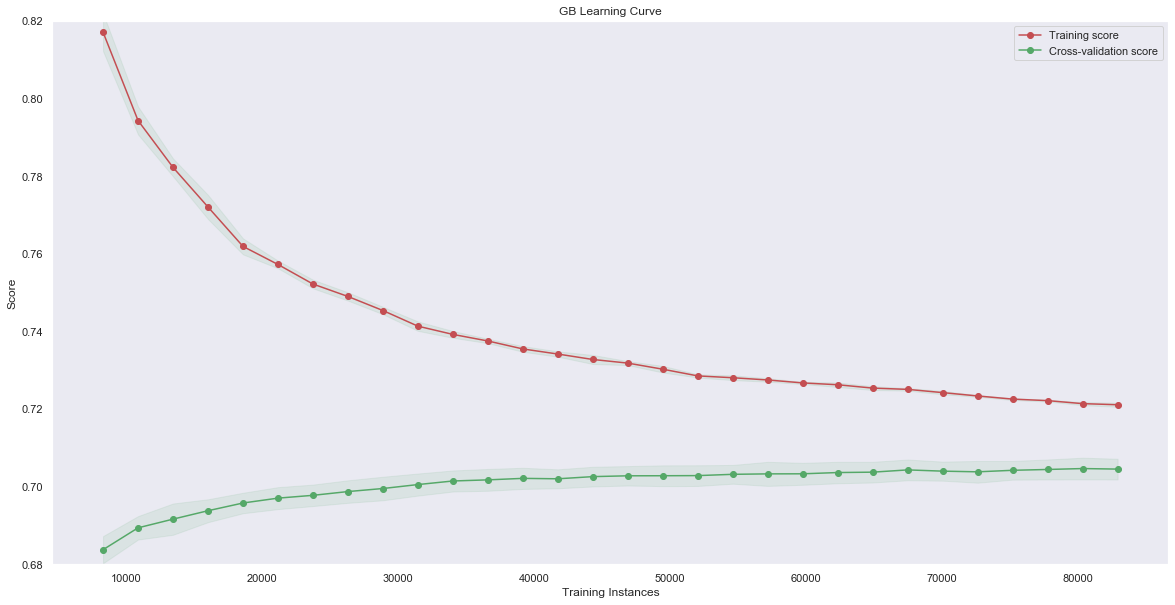

In [212]:
plot_learning_curve(gb_best, "GB Learning Curve", X_train, y_train, ylim=(0.68,0.82) ,cv=5, n_jobs=-1, \
                    train_sizes=np.linspace(0.1,1.0,30), figsize=(20,10))

In [242]:
pd.concat([pd.DataFrame(X_train.columns, columns=['variable']), \
          pd.DataFrame(gb_best.feature_importances_, columns=['importance'])], \
          axis=1).sort_values(by='importance' , ascending=False)

,variable,importance
1,int_rate_scaled,0.595536
3,dti_logged_scaled,0.088520
11,grade_num,0.082262
2,anl_inc_logged_scaled,0.057678
4,fico_range_low_scaled,0.044082
0,loan_amnt_scaled,0.037897
7,home_ownership_bin,0.030606
10,emp_length_num_scaled,0.025477
6,open_acc_logged_scaled,0.016422
5,total_acc_logged_scaled,0.011992


#### Observations of GB model:
* The GB model achieved a better roc_auc score of <0.7 which is acceptable for a first preliminary model. Although GB learning curve should be improved further, however, it's a healthier learning curve compared to LR and RF models.

### The Model of Choice: Gradient Boosting Classifier (3rd Model)
Here, we choose the GBC model over the other two models due to significantly better performance

In [215]:
y_pred = gb_best.predict(X_test)

In [216]:
y_pred

array([0, 1, 1, ..., 0, 0, 1])

In [217]:
y_pred_prob = gb_best.predict_proba(X_test)

In [218]:
y_pred_prob[:,1]

array([0.46615764, 0.50524042, 0.55627242, ..., 0.48452022, 0.48966624,
       0.67809785])

### Roc_Auc Curve on The Test-Set

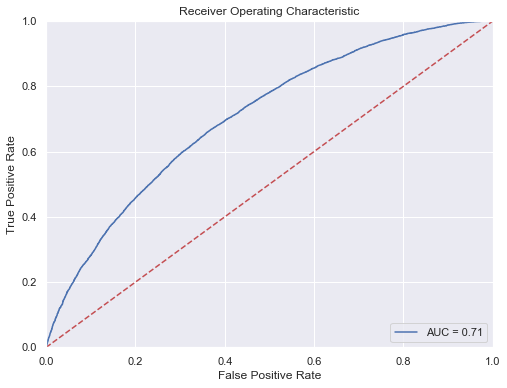

In [219]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = gb_best.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Confusion Matrix on Test Set

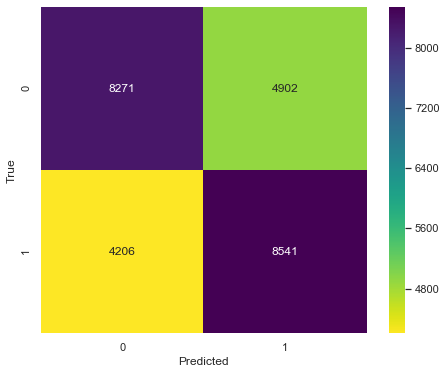

In [220]:
from sklearn.metrics import confusion_matrix

y_pred_test = gb_best.predict(X_test)

cm = confusion_matrix(y_test, y_pred_test)

fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

### Test Metrics

In [223]:
tn,fp,fn,tp = cm.ravel()

In [224]:
tn,fp,fn,tp

(8271, 4902, 4206, 8541)

In [225]:
recall = tp / (tp+fn)
specifity = tn / (tn+fp)
precision = tp/(tp+fp)
f1 = (2*tp) / (2*tp + fp + fn)

In [226]:
recall

0.6700400094139798

In [227]:
specifity

0.6278751992712366

In [228]:
precision

0.6353492523990181

In [229]:
f1

0.652233676975945

### How would this model can help with revenue increase?


#### 1) Priorotizing Loan Applications

Let's say there are 1000 loan applications that all passed initial assessments (i.e. there is no obvious red flag), and the business want to approve 500 out of these 1000 applications (based on the business capabilities). Currently, withough using any models, the business would have to randomly select 500 applications. 

Based on 2016 data, around 20% of the loands have led to charge-off status. That means, there will be approximately 100 (out of 500 approved) loans that will lead to charge-off. 

Now, suppose an alternative prioritization approach,  in which the 500 out of 1000 applications are chosen based on the GBC model (trained and tested above) predictions, i.e. based on the model probability predictions, the applications with less probability of charge-off are priorotized over the applications with higher probability of charge-off. 

Considering the roc_auc score of the GB model (~0.70),  it is statistically expected that the ratio of the charge-off to be reduced to 12%, instead of 20%. That means, in the examnple above, there will be 60 charge-off loans out of the 500 approved loans.

As a result, via using the GB model to priorotize 500 loan applications out of 1000 applications, instead of randomly choosing 500 applications, the business will approximately reduce the charge-off applications from 100 to 60, i.e. 40 less charge-off applications. If an average cost for a charge-off loan is 10K dollars for the buinsess, this will decrease loss, therefore increase revenue by 400K dollars.

#### 2) Adjusting Parameters such as Interest Rate, Loan Term, etc. to Optimize Revenue

One of the usefull insights the models can provide, is the feature importance. For instance, loan interest rate has been picked as an important feature, in terms of relationship with the loan status, by all the models. 

The feature importance analysis can give the business the tuning power if the business itself can willingly control or change the value for that feature. In our use-case, The interest rate is fully controlled and determined by the business. 

Being observed via the models that the interest rate has a direct affect to the loan status, the buinsess can seek for upgrade on its interest-rate evaluation method in order to generate a better balance between the number of charge-off and the cost resulting by loans charge-off, in order to increase the revenue. 

The insights provided by this modeling practice,  can direct the business to a new data science / ML solution: Developing a new model to estimate the optimal interest rate for each loan, to decrease the loss caused by charge-off loands, and therefore increase the revenue in total